In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='250-5d'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs/profiles-v1/profiles-v1-pca-5d'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
INPUT_PT_PATH = f"/workspace/datasets/profiles-v1/profiles-v1-pca-5d/profiles-v1-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v1_pca_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_250-5d_20250802_2118


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_250-5d_20250802_2118/density_plot.png


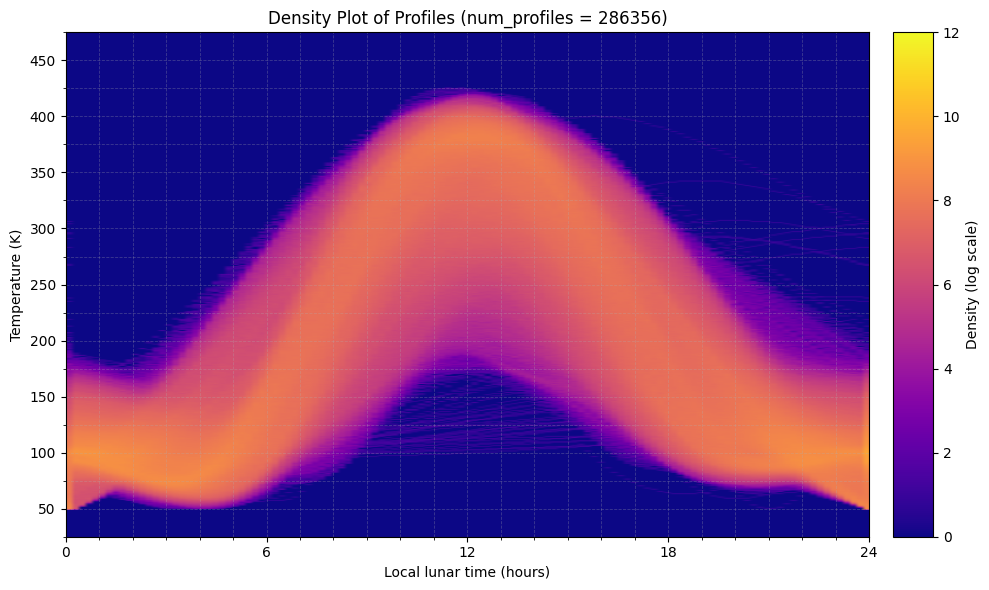

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 195.6345
STD: 98.5194
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 200449
Validation Data: 57271
Test Data: 28636


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.95it/s, best_loss=0.6182]


[Training] Epoch 1/100, L1 Loss: 0.6252, L2 Loss: 0.6654, KL Loss: 0.5388, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 287/287 [00:02<00:00, 101.06it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5363, Val L2 Loss: 0.5471, Val KL Loss: 0.6488
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_250-5d_20250802_2118'


[Training] Epoch 2/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.35it/s, best_loss=0.6052]


[Training] Epoch 2/100, L1 Loss: 0.5799, L2 Loss: 0.5921, KL Loss: 0.6476, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 287/287 [00:02<00:00, 101.85it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5406, Val KL Loss: 0.6520
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_250-5d_20250802_2118'


[Training] Epoch 3/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.56it/s, best_loss=0.6039]


[Training] Epoch 3/100, L1 Loss: 0.5789, L2 Loss: 0.5910, KL Loss: 0.6483, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 287/287 [00:02<00:00, 104.07it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5244, Val L2 Loss: 0.5382, Val KL Loss: 0.6561
[Validation] Saved checkpoint in '/workspace/outputs/profiles-v1/profiles-v1-pca-5d/profiles_v1_pca_250-5d_20250802_2118'


[Training] Epoch 4/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.63it/s, best_loss=0.6137]


[Training] Epoch 4/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6483, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 287/287 [00:02<00:00, 102.63it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5324, Val L2 Loss: 0.5444, Val KL Loss: 0.6332


[Training] Epoch 5/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.84it/s, best_loss=0.6031]


[Training] Epoch 5/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 287/287 [00:02<00:00, 107.25it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5420, Val KL Loss: 0.6422


[Training] Epoch 6/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.70it/s, best_loss=0.6062]


[Training] Epoch 6/100, L1 Loss: 0.5784, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 287/287 [00:02<00:00, 100.23it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5259, Val L2 Loss: 0.5393, Val KL Loss: 0.6518


[Training] Epoch 7/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.16it/s, best_loss=0.5925]


[Training] Epoch 7/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 287/287 [00:02<00:00, 101.15it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5281, Val L2 Loss: 0.5411, Val KL Loss: 0.6411


[Training] Epoch 8/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.44it/s, best_loss=0.6038]


[Training] Epoch 8/100, L1 Loss: 0.5783, L2 Loss: 0.5902, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 287/287 [00:02<00:00, 102.81it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5449, Val KL Loss: 0.6368


[Training] Epoch 9/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.41it/s, best_loss=0.6155]


[Training] Epoch 9/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 287/287 [00:02<00:00, 101.34it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5281, Val L2 Loss: 0.5409, Val KL Loss: 0.6502


[Training] Epoch 10/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.88it/s, best_loss=0.6047]


[Training] Epoch 10/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 287/287 [00:02<00:00, 96.23it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5267, Val L2 Loss: 0.5399, Val KL Loss: 0.6492


[Training] Epoch 11/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.92it/s, best_loss=0.6072]


[Training] Epoch 11/100, L1 Loss: 0.5788, L2 Loss: 0.5911, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 287/287 [00:02<00:00, 106.86it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5417, Val KL Loss: 0.6442


[Training] Epoch 12/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.69it/s, best_loss=0.6096]


[Training] Epoch 12/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 287/287 [00:02<00:00, 101.20it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5277, Val L2 Loss: 0.5408, Val KL Loss: 0.6457


[Training] Epoch 13/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.53it/s, best_loss=0.5892]


[Training] Epoch 13/100, L1 Loss: 0.5788, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 287/287 [00:02<00:00, 102.24it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5266, Val L2 Loss: 0.5398, Val KL Loss: 0.6550


[Training] Epoch 14/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.54it/s, best_loss=0.6160]


[Training] Epoch 14/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 287/287 [00:02<00:00, 98.40it/s] 


[Validation] Epoch 14/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5432, Val KL Loss: 0.6389


[Training] Epoch 15/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.99it/s, best_loss=0.5955]


[Training] Epoch 15/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 287/287 [00:02<00:00, 97.40it/s] 


[Validation] Epoch 15/100, Val L1 Loss: 0.5267, Val L2 Loss: 0.5403, Val KL Loss: 0.6529


[Training] Epoch 16/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.81it/s, best_loss=0.6208]


[Training] Epoch 16/100, L1 Loss: 0.5787, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 287/287 [00:02<00:00, 97.06it/s] 


[Validation] Epoch 16/100, Val L1 Loss: 0.5301, Val L2 Loss: 0.5426, Val KL Loss: 0.6428


[Training] Epoch 17/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.86it/s, best_loss=0.6159]


[Training] Epoch 17/100, L1 Loss: 0.5783, L2 Loss: 0.5903, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 287/287 [00:02<00:00, 101.06it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5424, Val KL Loss: 0.6472


[Training] Epoch 18/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.32it/s, best_loss=0.6116]


[Training] Epoch 18/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 287/287 [00:02<00:00, 100.85it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5267, Val L2 Loss: 0.5401, Val KL Loss: 0.6518


[Training] Epoch 19/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.04it/s, best_loss=0.5966]


[Training] Epoch 19/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 287/287 [00:02<00:00, 99.71it/s] 


[Validation] Epoch 19/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.5407, Val KL Loss: 0.6489


[Training] Epoch 20/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.90it/s, best_loss=0.6142]


[Training] Epoch 20/100, L1 Loss: 0.5781, L2 Loss: 0.5901, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 287/287 [00:02<00:00, 96.90it/s] 


[Validation] Epoch 20/100, Val L1 Loss: 0.5321, Val L2 Loss: 0.5438, Val KL Loss: 0.6343


[Training] Epoch 21/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.24it/s, best_loss=0.6170]


[Training] Epoch 21/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 287/287 [00:02<00:00, 101.33it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5412, Val KL Loss: 0.6441


[Training] Epoch 22/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.30it/s, best_loss=0.5936]


[Training] Epoch 22/100, L1 Loss: 0.5787, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 287/287 [00:02<00:00, 100.34it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5420, Val KL Loss: 0.6450


[Training] Epoch 23/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.27it/s, best_loss=0.6064]


[Training] Epoch 23/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 287/287 [00:02<00:00, 102.65it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5279, Val L2 Loss: 0.5407, Val KL Loss: 0.6489


[Training] Epoch 24/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.15it/s, best_loss=0.5938]


[Training] Epoch 24/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 287/287 [00:02<00:00, 100.53it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.5410, Val KL Loss: 0.6464


[Training] Epoch 25/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.33it/s, best_loss=0.6180]


[Training] Epoch 25/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 287/287 [00:02<00:00, 101.52it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5265, Val L2 Loss: 0.5399, Val KL Loss: 0.6567


[Training] Epoch 26/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.92it/s, best_loss=0.6151]


[Training] Epoch 26/100, L1 Loss: 0.5787, L2 Loss: 0.5910, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 287/287 [00:03<00:00, 91.18it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5312, Val L2 Loss: 0.5435, Val KL Loss: 0.6393


[Training] Epoch 27/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.97it/s, best_loss=0.6159]


[Training] Epoch 27/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 287/287 [00:02<00:00, 99.29it/s] 


[Validation] Epoch 27/100, Val L1 Loss: 0.5332, Val L2 Loss: 0.5450, Val KL Loss: 0.6337


[Training] Epoch 28/100: 100%|██████████| 1003/1003 [00:34<00:00, 28.95it/s, best_loss=0.6089]


[Training] Epoch 28/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 287/287 [00:02<00:00, 99.04it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.5410, Val KL Loss: 0.6433


[Training] Epoch 29/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.35it/s, best_loss=0.6199]


[Training] Epoch 29/100, L1 Loss: 0.5787, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 287/287 [00:02<00:00, 101.11it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5426, Val KL Loss: 0.6441


[Training] Epoch 30/100: 100%|██████████| 1003/1003 [00:34<00:00, 29.34it/s, best_loss=0.6194]


[Training] Epoch 30/100, L1 Loss: 0.5783, L2 Loss: 0.5903, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 287/287 [00:02<00:00, 103.40it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.5405, Val KL Loss: 0.6504


[Training] Epoch 31/100: 100%|██████████| 1003/1003 [00:33<00:00, 29.67it/s, best_loss=0.6165]


[Training] Epoch 31/100, L1 Loss: 0.5785, L2 Loss: 0.5905, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 287/287 [00:02<00:00, 108.24it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5437, Val KL Loss: 0.6397


[Training] Epoch 32/100: 100%|██████████| 1003/1003 [00:32<00:00, 31.01it/s, best_loss=0.6017]


[Training] Epoch 32/100, L1 Loss: 0.5789, L2 Loss: 0.5910, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 287/287 [00:02<00:00, 108.97it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.5411, Val KL Loss: 0.6440


[Training] Epoch 33/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.78it/s, best_loss=0.6190]


[Training] Epoch 33/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 287/287 [00:02<00:00, 106.16it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5285, Val L2 Loss: 0.5414, Val KL Loss: 0.6459


[Training] Epoch 34/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.90it/s, best_loss=0.6207]


[Training] Epoch 34/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 287/287 [00:02<00:00, 110.48it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5425, Val KL Loss: 0.6401


[Training] Epoch 35/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.82it/s, best_loss=0.6010]


[Training] Epoch 35/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 287/287 [00:02<00:00, 117.34it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5427, Val KL Loss: 0.6417


[Training] Epoch 36/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.35it/s, best_loss=0.6061]


[Training] Epoch 36/100, L1 Loss: 0.5788, L2 Loss: 0.5912, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 287/287 [00:02<00:00, 117.23it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5264, Val L2 Loss: 0.5398, Val KL Loss: 0.6576


[Training] Epoch 37/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.93it/s, best_loss=0.6002]


[Training] Epoch 37/100, L1 Loss: 0.5788, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 287/287 [00:02<00:00, 110.62it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5317, Val L2 Loss: 0.5437, Val KL Loss: 0.6354


[Training] Epoch 38/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.64it/s, best_loss=0.6124]


[Training] Epoch 38/100, L1 Loss: 0.5783, L2 Loss: 0.5904, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 287/287 [00:02<00:00, 101.87it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5422, Val KL Loss: 0.6434


[Training] Epoch 39/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.65it/s, best_loss=0.6083]


[Training] Epoch 39/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 287/287 [00:02<00:00, 109.56it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5429, Val KL Loss: 0.6419


[Training] Epoch 40/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.51it/s, best_loss=0.6196]


[Training] Epoch 40/100, L1 Loss: 0.5786, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 287/287 [00:02<00:00, 114.47it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5264, Val L2 Loss: 0.5398, Val KL Loss: 0.6509


[Training] Epoch 41/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.82it/s, best_loss=0.6149]


[Training] Epoch 41/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 287/287 [00:02<00:00, 109.79it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5281, Val L2 Loss: 0.5408, Val KL Loss: 0.6474


[Training] Epoch 42/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.67it/s, best_loss=0.6164]


[Training] Epoch 42/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 287/287 [00:02<00:00, 113.75it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5428, Val KL Loss: 0.6419


[Training] Epoch 43/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.24it/s, best_loss=0.6150]


[Training] Epoch 43/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 287/287 [00:02<00:00, 108.83it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5413, Val KL Loss: 0.6504


[Training] Epoch 44/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.00it/s, best_loss=0.6210]


[Training] Epoch 44/100, L1 Loss: 0.5786, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 287/287 [00:02<00:00, 114.03it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5268, Val L2 Loss: 0.5401, Val KL Loss: 0.6492


[Training] Epoch 45/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.06it/s, best_loss=0.6066]


[Training] Epoch 45/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 287/287 [00:02<00:00, 111.27it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5308, Val L2 Loss: 0.5427, Val KL Loss: 0.6399


[Training] Epoch 46/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.78it/s, best_loss=0.6019]


[Training] Epoch 46/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 287/287 [00:02<00:00, 111.31it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5275, Val L2 Loss: 0.5406, Val KL Loss: 0.6481


[Training] Epoch 47/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.37it/s, best_loss=0.6128]


[Training] Epoch 47/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 287/287 [00:02<00:00, 113.05it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5278, Val L2 Loss: 0.5408, Val KL Loss: 0.6505


[Training] Epoch 48/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.85it/s, best_loss=0.6093]


[Training] Epoch 48/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 287/287 [00:02<00:00, 104.41it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5442, Val KL Loss: 0.6335


[Training] Epoch 49/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.04it/s, best_loss=0.5972]


[Training] Epoch 49/100, L1 Loss: 0.5787, L2 Loss: 0.5910, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 287/287 [00:02<00:00, 106.94it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5275, Val L2 Loss: 0.5406, Val KL Loss: 0.6505


[Training] Epoch 50/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.14it/s, best_loss=0.6181]


[Training] Epoch 50/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 287/287 [00:02<00:00, 115.20it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5299, Val L2 Loss: 0.5423, Val KL Loss: 0.6443


[Training] Epoch 51/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.25it/s, best_loss=0.6025]


[Training] Epoch 51/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 287/287 [00:02<00:00, 115.35it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5431, Val KL Loss: 0.6375


[Training] Epoch 52/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.23it/s, best_loss=0.6000]


[Training] Epoch 52/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 287/287 [00:02<00:00, 107.06it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.5403, Val KL Loss: 0.6485


[Training] Epoch 53/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.86it/s, best_loss=0.6021]


[Training] Epoch 53/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 287/287 [00:02<00:00, 103.68it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5279, Val L2 Loss: 0.5407, Val KL Loss: 0.6484


[Training] Epoch 54/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.94it/s, best_loss=0.5991]


[Training] Epoch 54/100, L1 Loss: 0.5787, L2 Loss: 0.5907, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 287/287 [00:02<00:00, 106.92it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5279, Val L2 Loss: 0.5410, Val KL Loss: 0.6469


[Training] Epoch 55/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.04it/s, best_loss=0.6267]


[Training] Epoch 55/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 287/287 [00:02<00:00, 103.99it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5290, Val L2 Loss: 0.5416, Val KL Loss: 0.6465


[Training] Epoch 56/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.25it/s, best_loss=0.5869]


[Training] Epoch 56/100, L1 Loss: 0.5785, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 287/287 [00:02<00:00, 107.37it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5437, Val KL Loss: 0.6395


[Training] Epoch 57/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.87it/s, best_loss=0.6119]


[Training] Epoch 57/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 287/287 [00:02<00:00, 106.14it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5429, Val KL Loss: 0.6394


[Training] Epoch 58/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.70it/s, best_loss=0.6097]


[Training] Epoch 58/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 287/287 [00:02<00:00, 107.79it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5420, Val KL Loss: 0.6418


[Training] Epoch 59/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.96it/s, best_loss=0.5962]


[Training] Epoch 59/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 287/287 [00:02<00:00, 106.39it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5313, Val L2 Loss: 0.5434, Val KL Loss: 0.6380


[Training] Epoch 60/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.41it/s, best_loss=0.5446]


[Training] Epoch 60/100, L1 Loss: 0.5784, L2 Loss: 0.5903, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 287/287 [00:02<00:00, 109.48it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5455, Val KL Loss: 0.6371


[Training] Epoch 61/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.74it/s, best_loss=0.6063]


[Training] Epoch 61/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 287/287 [00:02<00:00, 111.61it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5298, Val L2 Loss: 0.5424, Val KL Loss: 0.6440


[Training] Epoch 62/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.12it/s, best_loss=0.5935]


[Training] Epoch 62/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 287/287 [00:02<00:00, 105.46it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5437, Val KL Loss: 0.6393


[Training] Epoch 63/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.03it/s, best_loss=0.6243]


[Training] Epoch 63/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 287/287 [00:02<00:00, 109.57it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5304, Val L2 Loss: 0.5429, Val KL Loss: 0.6434


[Training] Epoch 64/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.60it/s, best_loss=0.6010]


[Training] Epoch 64/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 287/287 [00:02<00:00, 117.40it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5412, Val KL Loss: 0.6458


[Training] Epoch 65/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.73it/s, best_loss=0.6121]


[Training] Epoch 65/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 287/287 [00:02<00:00, 112.61it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5402, Val KL Loss: 0.6507


[Training] Epoch 66/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.01it/s, best_loss=0.6092]


[Training] Epoch 66/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 287/287 [00:02<00:00, 110.95it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5416, Val KL Loss: 0.6472


[Training] Epoch 67/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.66it/s, best_loss=0.5849]


[Training] Epoch 67/100, L1 Loss: 0.5789, L2 Loss: 0.5910, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 287/287 [00:02<00:00, 113.96it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5275, Val L2 Loss: 0.5403, Val KL Loss: 0.6493


[Training] Epoch 68/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.02it/s, best_loss=0.6046]


[Training] Epoch 68/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 287/287 [00:02<00:00, 110.89it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5412, Val KL Loss: 0.6454


[Training] Epoch 69/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.38it/s, best_loss=0.6198]


[Training] Epoch 69/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 287/287 [00:02<00:00, 111.88it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5431, Val KL Loss: 0.6403


[Training] Epoch 70/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.19it/s, best_loss=0.5961]


[Training] Epoch 70/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 287/287 [00:02<00:00, 111.08it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5287, Val L2 Loss: 0.5414, Val KL Loss: 0.6413


[Training] Epoch 71/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.79it/s, best_loss=0.6248]


[Training] Epoch 71/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 287/287 [00:02<00:00, 107.70it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5349, Val L2 Loss: 0.5457, Val KL Loss: 0.6293


[Training] Epoch 72/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.14it/s, best_loss=0.6098]


[Training] Epoch 72/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 287/287 [00:02<00:00, 115.73it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5292, Val L2 Loss: 0.5417, Val KL Loss: 0.6432


[Training] Epoch 73/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.20it/s, best_loss=0.6005]


[Training] Epoch 73/100, L1 Loss: 0.5787, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 287/287 [00:02<00:00, 111.91it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5336, Val L2 Loss: 0.5451, Val KL Loss: 0.6292


[Training] Epoch 74/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.99it/s, best_loss=0.6213]


[Training] Epoch 74/100, L1 Loss: 0.5787, L2 Loss: 0.5908, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 287/287 [00:02<00:00, 111.59it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5250, Val L2 Loss: 0.5389, Val KL Loss: 0.6580


[Training] Epoch 75/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.18it/s, best_loss=0.5936]


[Training] Epoch 75/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 287/287 [00:02<00:00, 113.51it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5420, Val KL Loss: 0.6434


[Training] Epoch 76/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.83it/s, best_loss=0.6121]


[Training] Epoch 76/100, L1 Loss: 0.5787, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 287/287 [00:02<00:00, 117.71it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5295, Val L2 Loss: 0.5421, Val KL Loss: 0.6413


[Training] Epoch 77/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.99it/s, best_loss=0.5972]


[Training] Epoch 77/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 287/287 [00:02<00:00, 111.95it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5358, Val L2 Loss: 0.5465, Val KL Loss: 0.6304


[Training] Epoch 78/100: 100%|██████████| 1003/1003 [00:30<00:00, 33.22it/s, best_loss=0.6103]


[Training] Epoch 78/100, L1 Loss: 0.5786, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 287/287 [00:02<00:00, 110.68it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5420, Val KL Loss: 0.6438


[Training] Epoch 79/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.93it/s, best_loss=0.6128]


[Training] Epoch 79/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 287/287 [00:02<00:00, 110.19it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5426, Val KL Loss: 0.6381


[Training] Epoch 80/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.94it/s, best_loss=0.6100]


[Training] Epoch 80/100, L1 Loss: 0.5785, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 287/287 [00:02<00:00, 117.52it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5281, Val L2 Loss: 0.5412, Val KL Loss: 0.6457


[Training] Epoch 81/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.04it/s, best_loss=0.5844]


[Training] Epoch 81/100, L1 Loss: 0.5786, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 287/287 [00:02<00:00, 111.38it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5423, Val KL Loss: 0.6413


[Training] Epoch 82/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.84it/s, best_loss=0.6030]


[Training] Epoch 82/100, L1 Loss: 0.5788, L2 Loss: 0.5910, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 287/287 [00:02<00:00, 110.72it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5289, Val L2 Loss: 0.5416, Val KL Loss: 0.6444


[Training] Epoch 83/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.90it/s, best_loss=0.6183]


[Training] Epoch 83/100, L1 Loss: 0.5783, L2 Loss: 0.5903, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 287/287 [00:02<00:00, 118.56it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5440, Val KL Loss: 0.6336


[Training] Epoch 84/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.81it/s, best_loss=0.6050]


[Training] Epoch 84/100, L1 Loss: 0.5786, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 287/287 [00:02<00:00, 117.00it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5271, Val L2 Loss: 0.5402, Val KL Loss: 0.6517


[Training] Epoch 85/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.56it/s, best_loss=0.6060]


[Training] Epoch 85/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 287/287 [00:02<00:00, 118.94it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5268, Val L2 Loss: 0.5401, Val KL Loss: 0.6469


[Training] Epoch 86/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.10it/s, best_loss=0.5854]


[Training] Epoch 86/100, L1 Loss: 0.5784, L2 Loss: 0.5903, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 287/287 [00:02<00:00, 112.05it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5411, Val KL Loss: 0.6484


[Training] Epoch 87/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.38it/s, best_loss=0.6124]


[Training] Epoch 87/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 287/287 [00:02<00:00, 117.70it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5276, Val L2 Loss: 0.5408, Val KL Loss: 0.6458


[Training] Epoch 88/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.89it/s, best_loss=0.6134]


[Training] Epoch 88/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 287/287 [00:02<00:00, 113.84it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5426, Val KL Loss: 0.6438


[Training] Epoch 89/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.06it/s, best_loss=0.5811]


[Training] Epoch 89/100, L1 Loss: 0.5787, L2 Loss: 0.5908, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 287/287 [00:02<00:00, 110.53it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5428, Val KL Loss: 0.6422


[Training] Epoch 90/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.00it/s, best_loss=0.6172]


[Training] Epoch 90/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 287/287 [00:02<00:00, 113.11it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5259, Val L2 Loss: 0.5396, Val KL Loss: 0.6534


[Training] Epoch 91/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.25it/s, best_loss=0.6073]


[Training] Epoch 91/100, L1 Loss: 0.5786, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 287/287 [00:02<00:00, 109.02it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5291, Val L2 Loss: 0.5415, Val KL Loss: 0.6478


[Training] Epoch 92/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.68it/s, best_loss=0.6032]


[Training] Epoch 92/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6484, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 287/287 [00:02<00:00, 110.84it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5420, Val KL Loss: 0.6439


[Training] Epoch 93/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.02it/s, best_loss=0.6104]


[Training] Epoch 93/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 287/287 [00:02<00:00, 110.12it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5297, Val L2 Loss: 0.5422, Val KL Loss: 0.6413


[Training] Epoch 94/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.19it/s, best_loss=0.6053]


[Training] Epoch 94/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 287/287 [00:02<00:00, 111.09it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5302, Val L2 Loss: 0.5428, Val KL Loss: 0.6369


[Training] Epoch 95/100: 100%|██████████| 1003/1003 [00:30<00:00, 33.09it/s, best_loss=0.6027]


[Training] Epoch 95/100, L1 Loss: 0.5784, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 287/287 [00:02<00:00, 112.09it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5303, Val L2 Loss: 0.5428, Val KL Loss: 0.6446


[Training] Epoch 96/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.24it/s, best_loss=0.5964]


[Training] Epoch 96/100, L1 Loss: 0.5785, L2 Loss: 0.5906, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 287/287 [00:02<00:00, 113.10it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5252, Val L2 Loss: 0.5387, Val KL Loss: 0.6566


[Training] Epoch 97/100: 100%|██████████| 1003/1003 [00:31<00:00, 31.95it/s, best_loss=0.5970]


[Training] Epoch 97/100, L1 Loss: 0.5785, L2 Loss: 0.5907, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 287/287 [00:02<00:00, 110.26it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5336, Val L2 Loss: 0.5449, Val KL Loss: 0.6286


[Training] Epoch 98/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.22it/s, best_loss=0.6180]


[Training] Epoch 98/100, L1 Loss: 0.5785, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 287/287 [00:02<00:00, 114.50it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5274, Val L2 Loss: 0.5406, Val KL Loss: 0.6476


[Training] Epoch 99/100: 100%|██████████| 1003/1003 [00:31<00:00, 32.06it/s, best_loss=0.6242]


[Training] Epoch 99/100, L1 Loss: 0.5785, L2 Loss: 0.5905, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 287/287 [00:02<00:00, 106.69it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5275, Val L2 Loss: 0.5407, Val KL Loss: 0.6497


[Training] Epoch 100/100: 100%|██████████| 1003/1003 [00:30<00:00, 32.75it/s, best_loss=0.5991]


[Training] Epoch 100/100, L1 Loss: 0.5786, L2 Loss: 0.5909, KL Loss: 0.6485, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 287/287 [00:02<00:00, 114.35it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5282, Val L2 Loss: 0.5412, Val KL Loss: 0.6469


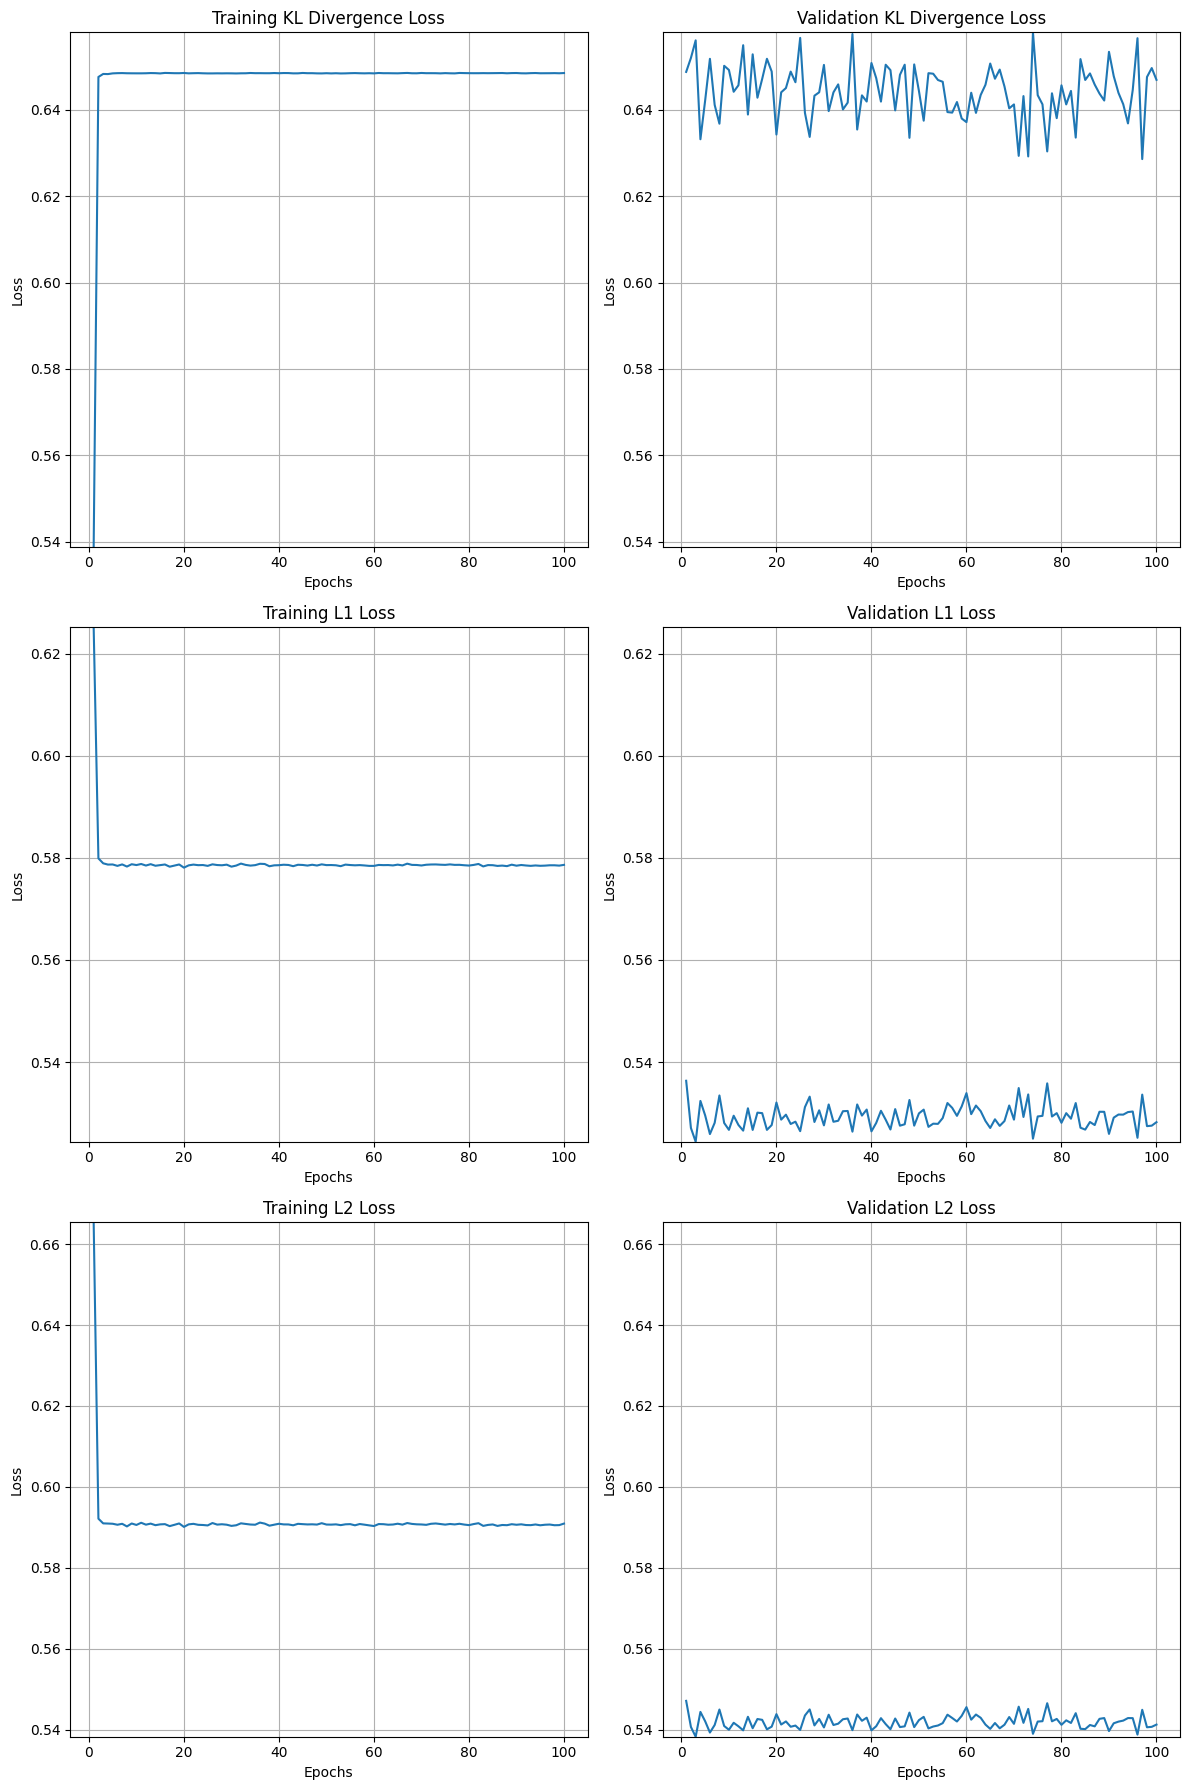

Best Validation Loss in Kelvins:
51.6619 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


z0: 0.0141
z1: -0.0410
z2: -0.0354
z3: 0.0082


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 752.18it/s]


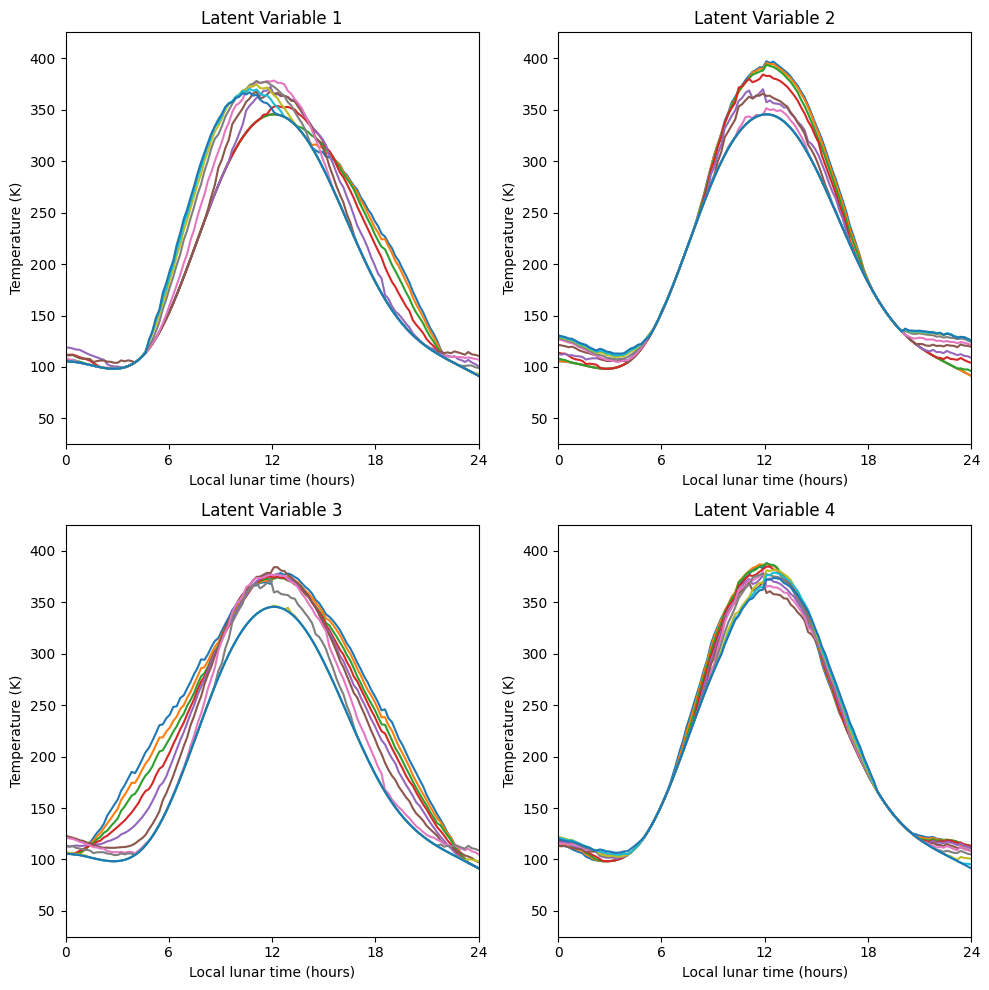

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)